In [1]:
    ###################################################################################################
    ####
    #este ejemplo esta basado en
    #https://blog.quantinsti.com/machine-learning-classification-strategy-python/?utm_source=quora&utm_medium=answer_is
    ####
    ###################################################################################################
    #Carga las librerías
    !pip install pandas_datareader
    !pip install ta
    !pip install pandas==0.24
    # Machine learning classification libraries
    from sklearn.svm import SVC
    from sklearn.metrics import scorer
    from sklearn.metrics import accuracy_score
     
    # For data manipulation
    import pandas as pd
    import numpy as np
    from ta import * 
     
    # To plot
    import matplotlib.pyplot as plt
    import seaborn
     
    # To fetch data
    from pandas_datareader import data as pdr

In [2]:
pd.__version__


'0.24.0'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')



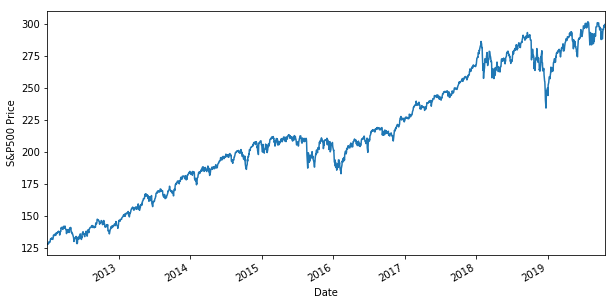

In [15]:
#importa los datos de Yahoo y los plotea

    Df = pdr.get_data_yahoo('SPY', start="2012-01-01") 
#    Df = pdr.get_data_yahoo('SPY', start="2012-01-01", end="2017-10-01") 
    
    Df= Df.dropna()
    Df.Close.plot(figsize=(10,5))
    plt.ylabel("S&P500 Price")
    plt.show()

In [16]:
#df.colums
print(Df.columns)
Df = utils.dropna(Df)
#Modificamos columnas de acciones
for item in ['Open', 'High', 'Low']:
    Df[item] = Df[item] * Df['Adj Close'] / Df['Close']
Df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low','Adj Close': 'close', 'Volume': 'volume'}, inplace=True)
Df.drop(['Close'],axis=1, inplace=True)
    
print(Df.columns)
print(Df.info())
print(Df.isna().sum())
print(Df.tail())
#Df=Df.dropna(inplace=True)

# Add all ta features filling nans values
Df = add_all_ta_features(Df, "open", "high", "low", "close", "volume",fillna=True)


Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['high', 'low', 'open', 'volume', 'close'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1965 entries, 2012-01-03 to 2019-10-23
Data columns (total 5 columns):
high      1965 non-null float64
low       1965 non-null float64
open      1965 non-null float64
volume    1965 non-null float64
close     1965 non-null float64
dtypes: float64(5)
memory usage: 92.1 KB
None
high      0
low       0
open      0
volume    0
close     0
dtype: int64
                  high         low        open      volume       close
Date                                                                  
2019-10-17  300.239990  298.519989  299.679993  45736600.0  299.279999
2019-10-18  299.399994  297.029999  298.690002  64304000.0  297.970001
2019-10-21  300.209991  298.940002  299.420013  39048600.0  299.989990
2019-10-22  300.899994  298.910004  300.579987  48594700.0  299.010010
2019-10-23  299.940002  29

/usr/local/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


In [19]:
Df.columns

Index(['high', 'low', 'open', 'volume', 'close', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_vpt', 'volume_nvi',
       'volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_bbm',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dch', 'volatility_dcl',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'momentum_rsi', 

In [17]:
# Variable a estimar
Df['Return3'] = np.log(Df.close.shift(-2) / Df.close.shift(-1))
y = pd.DataFrame(np.where(Df['Return3']> 0,1,-1))
#y=y.shift(-1)
y=y.fillna(0)
y.tail()


,0
1960,1
1961,-1
1962,1
1963,-1
1964,-1


In [7]:
# Creaación de Features
    Df['Open-Close'] = Df.open - Df.close
    Df['High-Low'] = Df.high - Df.low
     
    X=Df[['Open-Close','High-Low']]
    ''' 	Open-Close 	High-Low
Date 		
2017-09-25 	0.220001 	1.470001
2017-09-26 	0.339996 	0.889999
2017-09-27 	-0.169998 	1.620010
2017-09-28 	-0.620010 	0.809998
2017-09-29 	-0.889999 	1.190002'''
    X.tail()
    

,Open-Close,High-Low
Date,,
2019-10-17,0.399994,1.720001
2019-10-18,0.720001,2.369995
2019-10-21,-0.569977,1.269989
2019-10-22,1.569977,1.989990
2019-10-23,-1.099976,1.440002


In [21]:
#Vemos la multicolinealidad con la correlación entre las features
features=list(Df.columns[5:])
np.round(Df[features].corr(),2)

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,others_dr,others_dlr,others_cr,Return3
volume_adi,1.00,-0.05,0.33,0.24,0.17,0.45,-0.06,-0.04,-0.09,-0.09,...,0.44,0.52,0.32,0.52,0.06,-0.08,0.35,0.51,-0.06,-0.03
volume_obv,-0.05,1.00,-0.01,-0.03,0.07,0.06,0.70,0.40,0.83,0.83,...,0.11,0.09,0.10,0.09,0.13,0.84,0.05,0.01,0.84,-0.03
volume_cmf,0.33,-0.01,1.00,0.17,0.34,0.20,-0.06,-0.33,-0.08,-0.06,...,0.67,0.46,0.51,0.46,0.59,-0.05,0.17,0.11,-0.04,-0.03
volume_fi,0.24,-0.03,0.17,1.00,0.23,0.27,-0.03,-0.14,-0.06,-0.05,...,0.24,0.26,0.23,0.26,0.17,-0.04,0.18,0.30,-0.03,-0.00
volume_em,0.17,0.07,0.34,0.23,1.00,0.15,0.04,-0.28,-0.01,0.02,...,0.45,0.51,0.58,0.51,0.71,0.03,0.07,0.12,0.06,-0.05
volume_vpt,0.45,0.06,0.20,0.27,0.15,1.00,0.02,-0.03,0.02,0.02,...,0.32,0.32,0.21,0.32,0.05,0.02,0.68,0.38,0.04,-0.04
volume_nvi,-0.06,0.70,-0.06,-0.03,0.04,0.02,1.00,0.62,0.97,0.96,...,0.02,0.03,0.03,0.03,0.03,0.96,0.02,-0.01,0.96,-0.01
volatility_atr,-0.04,0.40,-0.33,-0.14,-0.28,-0.03,0.62,1.00,0.59,0.53,...,-0.22,-0.16,-0.21,-0.16,-0.46,0.55,0.00,0.00,0.54,0.03
volatility_bbh,-0.09,0.83,-0.08,-0.06,-0.01,0.02,0.97,0.59,1.00,0.99,...,0.01,0.01,0.01,0.01,0.03,1.00,0.02,-0.02,1.00,-0.02
volatility_bbl,-0.09,0.83,-0.06,-0.05,0.02,0.02,0.96,0.53,0.99,1.00,...,0.01,0.01,0.02,0.01,0.07,1.00,0.01,-0.02,1.00,-0.03


In [28]:
X=Df[features]

In [29]:
# Split la muestra entre InSample y OutSample
    split_percentage = 0.8
    split = int(split_percentage*len(Df))
     
    # Train data set
    X_train = X[:split]
    y_train = y[:split]
     
    # Test data set
    X_test = X[split:]
    y_test = y[split:]
    '''            Open-Close  High-Low
Date                            
2016-08-01    0.250000  1.239990
2016-08-02    1.099991  2.259995
2016-08-03   -0.699997  1.119995
2016-08-04   -0.100006  2.529999
2016-08-05   -1.769989  1.819992
      0
1151 -1
1152  1
1153  1
1154  1
1155 -1'''
    
    print(X_train.tail())
    print(y_train.tail())


              volume_adi    volume_obv  volume_cmf     volume_fi  \
Date                                                               
2018-03-27  5.460193e+07  7.076769e+09   -0.180571 -1.328010e+08   
2018-03-28 -1.285351e+08  6.930317e+09   -0.156993 -2.306916e+07   
2018-03-29 -3.156453e+07  7.041918e+09   -0.106937 -4.544485e+07   
2018-04-02 -3.826778e+07  6.855632e+09   -0.180176 -9.134967e+07   
2018-04-03  2.799739e+07  6.975589e+09   -0.169552 -1.932354e+07   

               volume_em    volume_vpt   volume_nvi  volatility_atr  \
Date                                                                  
2018-03-27 -2.508554e-08  1.673254e+06  5614.371943        4.459346   
2018-03-28 -3.217492e-08 -2.643299e+06  5614.371943        4.422626   
2018-03-29 -3.366714e-08  9.932730e+05  5686.111676        4.483624   
2018-04-02 -4.806509e-08 -2.594922e+06  5686.111676        4.751961   
2018-04-03 -4.515556e-08 -2.483444e+06  5758.991559        4.722796   

            volatility_bb

In [30]:
#Creamos el modelo
    cls = SVC(gamma='auto').fit(X_train.values, np.ravel(y_train))

In [31]:
from sklearn.metrics import confusion_matrix
import itertools


# Predict the values from the validation dataset
Y_pred = cls.predict(X_test)
confusion_mtx = confusion_matrix(y_test, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = [-1,1])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [25]:
#aquí vemos el ajuste del modelo
    accuracy_train = accuracy_score(y_train, cls.predict(X_train))
     
    accuracy_test = accuracy_score(y_test, cls.predict(X_test))
    print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
    print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 55.92%
Test Accuracy: 54.45%


In [26]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
    Df['Return1'] = Df.Close.pct_change().shift(-2)*100
    
    Df['Strategy_Return'] = Df.Return.shift(-1) * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return1.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



AttributeError: 'DataFrame' object has no attribute 'Close'

In [ ]:
# Calculate log returns
    Df['Return'] = Df.Close.pct_change().shift(-2)
    Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()


In [ ]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close / Df.Close.shift(1))*100
    Df['Strategy_Return'] = Df.Return.shift(-2) * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



In [ ]:
    Df['signal']=y
    Df['Return1'] = np.log(Df.Close / Df.Close.shift(1))
    Df['Return2'] = Df.Close.pct_change().shift(-1)
    Df['Return3'] = np.log(Df.Close.shift(-1) / Df.Close)

    Df[['Return1','Return2','Return3','Predicted_Signal','signal']].tail()
